In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import download
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py
    

2023-03-17 15:05:33.414625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
keras.__version__

'2.11.0'

In [3]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()
     

In [4]:
in_dir = '/Users/elijahadedamola/Documents/project_dataset/data2/fights'

In [5]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [6]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [17]:
def get_frames(current_dir, file_name):
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    spectrograms = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count < _images_per_file:
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                          interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
        
        # Compute spectrogram of motion blur
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur_img = cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)
        _, _, spectrogram = plt.specgram(blur_img, Fs=1, cmap='gray', NFFT=nfft, noverlap=noverlap)
        spectrogram_resized = cv2.resize(spectrogram, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        spectrograms.append(spectrogram_resized[..., np.newaxis])
    
        success, image = vidcap.read()
    
        count += 1
        
    frames = np.array(images)
    frames = (frames / 255.).astype(np.float16)
    
    spectrograms = np.array(spectrograms)
    spectrograms = (spectrograms - np.min(spectrograms)) / (np.max(spectrograms) - np.min(spectrograms))
    
    frames_with_spectrograms = np.concatenate((frames, spectrograms), axis=-1)
    
    return frames_with_spectrograms


In [18]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'ne':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [19]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

In [20]:

names[12]

'newfi11.avi'

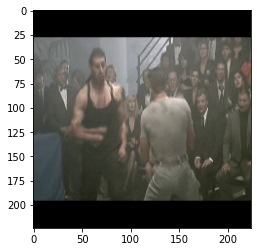

In [12]:
plt.imshow(visible_frame[3])

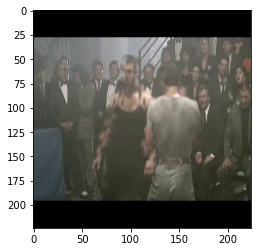

In [13]:
plt.imshow(visible_frame[15])

In [14]:
image_model = VGG16(include_top=True, weights='imagenet')

2023-03-08 13:02:04.422008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:

image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape
     

[]

In [17]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)
     

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [18]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [19]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [20]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1
     


In [21]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1


In [22]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]
     

In [23]:
make_files(training_set)

1/1 [==============================] - 5s 5s/step
- Progress: 99.2%

In [24]:
make_files_test(test_set)

1/1 [==============================] - 6s 6s/step
- Progress: 96.7%

In [25]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target
     


In [26]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target
     


In [27]:
data, target = process_alldata_training()
     

In [28]:
data_test, target_test = process_alldata_test()

In [29]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [30]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)
     

Epoch 1/200
1/1 - 3s - loss: 0.2335 - accuracy: 0.6583 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 0.2913 - accuracy: 0.6583 - 643ms/epoch - 643ms/step
Epoch 3/200
1/1 - 1s - loss: 0.2373 - accuracy: 0.6583 - 616ms/epoch - 616ms/step
Epoch 4/200
1/1 - 1s - loss: 0.2574 - accuracy: 0.3417 - 613ms/epoch - 613ms/step
Epoch 5/200
1/1 - 1s - loss: 0.2204 - accuracy: 0.6583 - 654ms/epoch - 654ms/step
Epoch 6/200
1/1 - 1s - loss: 0.2219 - accuracy: 0.6583 - 636ms/epoch - 636ms/step
Epoch 7/200
1/1 - 1s - loss: 0.2250 - accuracy: 0.6583 - 670ms/epoch - 670ms/step
Epoch 8/200
1/1 - 1s - loss: 0.2144 - accuracy: 0.6583 - 704ms/epoch - 704ms/step
Epoch 9/200
1/1 - 1s - loss: 0.2042 - accuracy: 0.6583 - 747ms/epoch - 747ms/step
Epoch 10/200
1/1 - 1s - loss: 0.1983 - accuracy: 0.6583 - 781ms/epoch - 781ms/step
Epoch 11/200
1/1 - 1s - loss: 0.1857 - accuracy: 0.6583 - 808ms/epoch - 808ms/step
Epoch 12/200
1/1 - 1s - loss: 0.1700 - accuracy: 0.6583 - 821ms/epoch - 821ms/step
Epoch 13/200
1/1 - 

Epoch 101/200
1/1 - 1s - loss: 9.0926e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 102/200
1/1 - 1s - loss: 8.9894e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 103/200
1/1 - 1s - loss: 8.8941e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 104/200
1/1 - 1s - loss: 8.8044e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 105/200
1/1 - 1s - loss: 8.7173e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 106/200
1/1 - 1s - loss: 8.6304e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 107/200
1/1 - 1s - loss: 8.5421e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 108/200
1/1 - 1s - loss: 8.4520e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 109/200
1/1 - 1s - loss: 8.3604e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 110/200
1/1 - 1s - loss: 8.2685e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 111/200
1/1 - 1s - loss: 8.1775e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 112/200
1/1 - 1s - loss: 8.0885e-05 - accuracy: 1.0000 - 1s/epoch - 1s/step
Epoch 113/200
1/

In [31]:
result = model.evaluate(np.array(data_test), np.array(target_test))

1/1 [==============================] - 0s 485ms/step - loss: 0.0031 - accuracy: 1.0000


In [32]:
for name, value in zip(model.metrics_names, result):
    print(name, value)
     

loss 0.003077015746384859
accuracy 1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


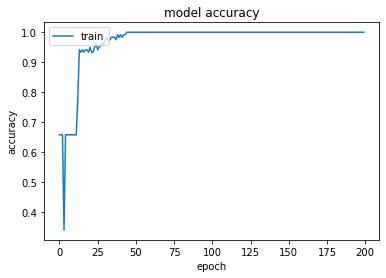

In [40]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


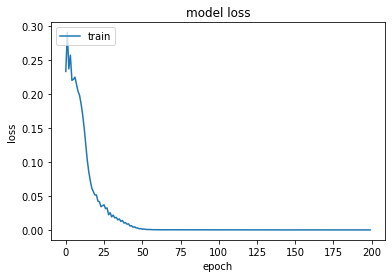

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()